In [1]:
import os  
import glob
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import PIL 
import random
import numpy as np
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torchvision.models as models
from efficientnet_pytorch import EfficientNet
from torchinfo import summary 

import torch.optim as optim
from IPython.display import Image
from torch.utils.data import DataLoader, Dataset

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.nn.functional as F


import cv2
import pydicom
import matplotlib.pyplot as plt

In [2]:
from duke_dbt_data import dcmread_image

In [3]:
boxes_train = pd.read_csv("D:\LUCAS\PIBIC\DATASET\CANCER_IMAGING_ARCHIVE\BCS-DBT boxes-train-v2.csv")               #Not Use yet
file_path_test = pd.read_csv("D:\LUCAS\PIBIC\DATASET\CANCER_IMAGING_ARCHIVE\BCS-DBT file-paths-test-v2.csv")        #Not Use
file_path_train = pd.read_csv("D:\LUCAS\PIBIC\DATASET\CANCER_IMAGING_ARCHIVE\BCS-DBT file-paths-train-v2.csv")      
labels_train = pd.read_csv("D:\LUCAS\PIBIC\DATASET\CANCER_IMAGING_ARCHIVE\BCS-DBT labels-train-v2.csv")
file_path_valid = pd.read_csv("D:\LUCAS\PIBIC\DATASET\CANCER_IMAGING_ARCHIVE\BCS-DBT file-paths-validation-v2.csv") #Not Use

In [4]:
file_path_test

,PatientID,StudyUID,View,descriptive_path,classic_path
0,DBT-P00036,DBT-S03354,lcc,Breast-Cancer-Screening-DBT/DBT-P00036/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P00036/1.2.826...
1,DBT-P00036,DBT-S03354,lmlo,Breast-Cancer-Screening-DBT/DBT-P00036/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P00036/1.2.826...
2,DBT-P00036,DBT-S03354,rcc,Breast-Cancer-Screening-DBT/DBT-P00036/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P00036/1.2.826...
3,DBT-P00036,DBT-S03354,rmlo,Breast-Cancer-Screening-DBT/DBT-P00036/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P00036/1.2.826...
4,DBT-P00087,DBT-S04170,lcc,Breast-Cancer-Screening-DBT/DBT-P00087/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P00087/1.2.826...
...,...,...,...,...,...
1716,DBT-P04790,DBT-S04022,rmlo,Breast-Cancer-Screening-DBT/DBT-P04790/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P04790/1.2.826...
1717,DBT-P00129,DBT-S03696,lcc,Breast-Cancer-Screening-DBT/DBT-P00129/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P00129/1.2.826...
1718,DBT-P00129,DBT-S03696,lmlo,Breast-Cancer-Screening-DBT/DBT-P00129/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P00129/1.2.826...
1719,DBT-P00129,DBT-S03696,rcc,Breast-Cancer-Screening-DBT/DBT-P00129/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P00129/1.2.826...


### Plot some images

In [5]:
df = file_path_test
view_series = df.iloc[0]
view = view_series["View"]
# if you have image data saved in classic path folder structure, read the file path from "classic_path"
# image_path = os.path.join("D:/LUCAS/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/test/manifest-1617905855234/", view_series["descriptive_path"])
image_path = "D:/LUCAS/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/test/manifest-1617905855234/Breast-Cancer-Screening-DBT/DBT-P00036/01-01-2000-DBT-S03354-MAMMO screening digital bilateral-14628/12278.000000-NA-02208/1-1.dcm"

c:\Users\Lucas\anaconda3\envs\torch000\lib\site-packages\openjpeg\utils.py:209: UserWarning: The (0028,0101) Bits Stored value '10' in the dataset does not match the component precision value '16' found in the JPEG 2000 data. It's recommended that you change the Bits Stored value to produce the correct output
  warnings.warn(


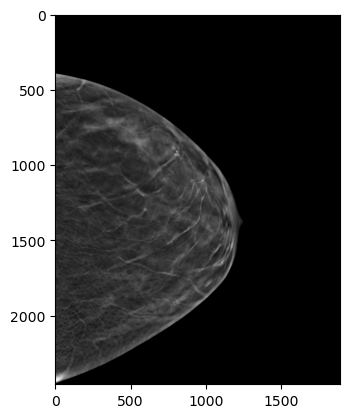

In [6]:
image = dcmread_image(fp=image_path, view=view)
plt.imshow(image[1], cmap=plt.cm.gray);

In [7]:
# Load the DICOM image
dicom_data = pydicom.dcmread(image_path)
dicom_data

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 212
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Breast Tomosynthesis Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.57714726666691444604469114206836806683
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'TOMOSYNTHESIS', 'NONE']
(0008, 0016) SOP Class UID                       UI: Breast Tomosynthesis Image Storage
(0008, 0018) SOP Instan

In [8]:
unique_pat = list(pd.unique(labels_train["PatientID"]))

In [9]:
neg_pat = []
pos_pat = []
for pat in unique_pat:
    flag = list(labels_train.loc[labels_train["PatientID"] == pat]['Cancer'])
    if flag[0]:
        pos_pat.append(pat)
    else:
        neg_pat.append(pat)
print(f"Patient with cancer {len(pos_pat)}")
print(f"Patient with not cancer {len(neg_pat)}")

Patient with cancer 39
Patient with not cancer 4323


### Fix file_path_train

In [10]:
base_path = "D:/LUCAS/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/train/manifest-1617905855234"

In [11]:
# Path to add in front
base_path = "D:/LUCAS/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/train/manifest-1617905855234"

# Function to replace the last hyphen with "-NA-" in the last folder
def replace_last_hyphen(path):
    parts = path.split("/")
    last_folder = parts[-2]
    last_hyphen_index = last_folder.rfind("-")
    if last_hyphen_index != -1:
        parts[-2] = last_folder[:last_hyphen_index] + "-NA-" + last_folder[last_hyphen_index+1:]
    return "/".join(parts)

# Apply the function to the descriptive_path column
file_path_train["descriptive_path"] = file_path_train["descriptive_path"].apply(replace_last_hyphen)

# Concatenate the base path with the updated "descriptive_path"
file_path_train["fullpath"] = base_path + "/" + file_path_train["descriptive_path"]

file_path_train


,PatientID,StudyUID,View,descriptive_path,classic_path,fullpath
0,DBT-P00013,DBT-S00163,rmlo,Breast-Cancer-Screening-DBT/DBT-P00013/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P00013/1.2.826...,D:/LUCAS/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/...
1,DBT-P00023,DBT-S04378,lcc,Breast-Cancer-Screening-DBT/DBT-P00023/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P00023/1.2.826...,D:/LUCAS/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/...
2,DBT-P00023,DBT-S04378,lmlo,Breast-Cancer-Screening-DBT/DBT-P00023/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P00023/1.2.826...,D:/LUCAS/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/...
3,DBT-P00023,DBT-S04378,rcc,Breast-Cancer-Screening-DBT/DBT-P00023/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P00023/1.2.826...,D:/LUCAS/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/...
4,DBT-P00023,DBT-S04378,rmlo,Breast-Cancer-Screening-DBT/DBT-P00023/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P00023/1.2.826...,D:/LUCAS/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/...
...,...,...,...,...,...,...
19143,DBT-P04356,DBT-S00073,rmlo,Breast-Cancer-Screening-DBT/DBT-P04356/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P04356/1.2.826...,D:/LUCAS/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/...
19144,DBT-P01481,DBT-S01753,lcc,Breast-Cancer-Screening-DBT/DBT-P01481/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P01481/1.2.826...,D:/LUCAS/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/...
19145,DBT-P01481,DBT-S01753,lmlo,Breast-Cancer-Screening-DBT/DBT-P01481/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P01481/1.2.826...,D:/LUCAS/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/...
19146,DBT-P01481,DBT-S01753,rcc,Breast-Cancer-Screening-DBT/DBT-P01481/01-01-2...,Breast-Cancer-Screening-DBT/DBT-P01481/1.2.826...,D:/LUCAS/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/...


In [12]:
file_path_train["fullpath"][1]

'D:/LUCAS/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/train/manifest-1617905855234/Breast-Cancer-Screening-DBT/DBT-P00023/01-01-2000-DBT-S04378-MAMMO SCREENING DIGITAL BILATERAL-20650/19711.000000-NA-14072/1-1.dcm'

### Split Data

In [13]:
merged_df = pd.merge(file_path_train, labels_train, on="PatientID")
merged_df  = merged_df[['PatientID', 'StudyUID_x', 'View_x', 'fullpath', 'StudyUID_y', 'View_y', 'Cancer']]
merged_df

,PatientID,StudyUID_x,View_x,fullpath,StudyUID_y,View_y,Cancer
0,DBT-P00013,DBT-S00163,rmlo,D:/LUCAS/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/...,DBT-S00163,rmlo,0
1,DBT-P00023,DBT-S04378,lcc,D:/LUCAS/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/...,DBT-S04378,lcc,0
2,DBT-P00023,DBT-S04378,lcc,D:/LUCAS/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/...,DBT-S04378,lmlo,0
3,DBT-P00023,DBT-S04378,lcc,D:/LUCAS/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/...,DBT-S04378,rcc,0
4,DBT-P00023,DBT-S04378,lcc,D:/LUCAS/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/...,DBT-S04378,rmlo,0
...,...,...,...,...,...,...,...
91569,DBT-P01481,DBT-S01753,rcc,D:/LUCAS/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/...,DBT-S01753,rmlo,0
91570,DBT-P01481,DBT-S01753,rmlo,D:/LUCAS/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/...,DBT-S01753,lcc,0
91571,DBT-P01481,DBT-S01753,rmlo,D:/LUCAS/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/...,DBT-S01753,lmlo,0
91572,DBT-P01481,DBT-S01753,rmlo,D:/LUCAS/PIBIC/DATASET/CANCER_IMAGING_ARCHIVE/...,DBT-S01753,rcc,0


In [14]:
import random

def split_patients(pos_patients, neg_patients, train_ratio=0.8, test_ratio=0.1, val_ratio=0.1):
    # Embaralhe a ordem dos pacientes
    random.shuffle(pos_patients)
    random.shuffle(neg_patients)
    
    # Divida os pacientes em conjuntos de treino, teste e valid
    total_patients = pos_patients + neg_patients
    num_patients = len(total_patients)
    
    train_end = int(num_patients * train_ratio)
    test_end = int(num_patients * (train_ratio + test_ratio))
    
    train_patients = set(total_patients[:train_end])
    test_patients = set(total_patients[train_end:test_end])
    valid_patients = set(total_patients[test_end:])
    
    return train_patients, test_patients, valid_patients

# Exemplo de uso
train_patients, test_patients, valid_patients = split_patients(pos_pat, neg_pat)

# Obtenha os "fullpath" correspondentes para cada conjunto de pacientes
train_fullpath = merged_df[merged_df['PatientID'].isin(train_patients)]['fullpath'].tolist()
train_label = merged_df[merged_df['PatientID'].isin(train_patients)]['Cancer'].tolist()

test_fullpath = merged_df[merged_df['PatientID'].isin(test_patients)]['fullpath'].tolist()
test_label = merged_df[merged_df['PatientID'].isin(test_patients)]['Cancer'].tolist()

valid_fullpath = merged_df[merged_df['PatientID'].isin(valid_patients)]['fullpath'].tolist()
valid_label = merged_df[merged_df['PatientID'].isin(valid_patients)]['Cancer'].tolist()


In [15]:
train_fullpath = list(set(train_fullpath))
train_label = list(set(train_label))

test_fullpath = list(set(test_fullpath))
test_label = list(set(test_label))

valid_fullpath = list(set(valid_fullpath))
valid_label = list(set(valid_label))

In [17]:
train_df = merged_df[merged_df['PatientID'].isin(train_patients)]
test_df = merged_df[merged_df['PatientID'].isin(test_patients)]
valid_df = merged_df[merged_df['PatientID'].isin(valid_patients)]

In [18]:
print("Número de pacientes no conjunto de treino:", len(train_patients))
print("Número de pacientes no conjunto de teste:", len(test_patients))
print("Número de pacientes no conjunto de validação:", len(valid_patients))

Número de pacientes no conjunto de treino: 3489
Número de pacientes no conjunto de teste: 436
Número de pacientes no conjunto de validação: 437


In [19]:
len(neg_pat) + len(pos_pat) == len(train_patients)+len(test_patients)+len(valid_patients)

True

In [29]:
print("Fullpath para treino:", len(train_fullpath))
print("Fullpath para teste:", len(test_fullpath))
print("Fullpath para validação:", len(valid_fullpath))

Fullpath para treino: 15271
Fullpath para teste: 1929
Fullpath para validação: 1948


In [20]:
labels_train.shape[0]

19148

In [23]:
int(labels_train.shape[0]) == len(train_fullpath) + len(test_fullpath) + len(valid_fullpath)

True

In [27]:
from collections import Counter

def encontrar_duplicatas(lista):
    contagem = Counter(lista)
    duplicatas = {item: count for item, count in contagem.items() if count > 1}
    return duplicatas

# Exemplo de lista
minha_lista = valid_fullpath

# Encontrar duplicatas
duplicatas = encontrar_duplicatas(minha_lista)

# Exibir as duplicatas encontradas
print("Duplicatas na lista:")
for item, count in duplicatas.items():
    print(f"O item {item} aparece {count} vezes.")


Duplicatas na lista:


In [26]:
def encontrar_elementos_comuns(lista1, lista2, lista3):
    # Converte as listas para conjuntos para facilitar a interseção
    conjunto1 = set(lista1)
    conjunto2 = set(lista2)
    conjunto3 = set(lista3)

    # Encontra os elementos que estão presentes em todas as listas
    elementos_comuns = conjunto1.intersection(conjunto2, conjunto3)
    return list(elementos_comuns)

# Exemplo de listas
lista1 = train_fullpath
lista2 = test_fullpath
lista3 = valid_fullpath

# Encontrar elementos comuns
elementos_comuns = encontrar_elementos_comuns(lista1, lista2, lista3)

# Exibir os elementos comuns
print("Elementos comuns nas três listas:", elementos_comuns)


Elementos comuns nas três listas: []
